# 🧠 Part 1: Project Introduction - Semantic Segmentation with U-Net

In this project, we will build and train a **U-Net**, one of the most influential architectures for **semantic segmentation**.

---

### 📌 What is Semantic Segmentation?

Unlike **object detection**, which places a bounding box around an object, **semantic segmentation** assigns a **class label to every single pixel** in an image. 

This process creates a **detailed, pixel-level mask** for each object category present in the scene.

---

### 🎯 Why It Matters

The result is a **far richer understanding** of the image's content — enabling fine-grained analysis and applications in fields like:

- Medical imaging
- Autonomous driving
- Satellite imagery
- Agricultural monitoring

---

Stay tuned as we dive deeper into building and training the U-Net architecture in the next parts!


# 🔍 Part 2: What is a U-Net?

The **U-Net** is a type of Convolutional Neural Network (CNN) named for its distinctive **U-shaped architecture**. It was originally designed for **fast and precise segmentation of biomedical images**, but has since proven incredibly effective for a wide range of computer vision tasks.

---

## 🧱 Core Concepts

### 🔹 1. Encoder-Decoder Structure

The architecture consists of two main paths:

#### 🔸 Encoder (Contracting Path)
- A traditional stack of **convolutional** and **max-pooling** layers.
- It progressively **downsamples** the image to capture **contextual information** (the *"what"*).
- Each downsampling step **doubles the number of feature channels**.

#### 🔸 Decoder (Expanding Path)
- Uses **up-convolutions** (transposed convolutions) to **upsample** feature maps.
- Gradually restores the spatial resolution, enabling **precise localization** (the *"where"*).

---

### 🔹 2. Skip Connections

- This is the **most critical feature** of the U-Net.
- The output from each encoder layer is **directly connected** to the corresponding decoder layer.
- These **skip connections** provide the decoder with **high-resolution feature maps** from earlier layers.
- This helps recover **fine-grained details** and **spatial information** lost during downsampling.

> 🔑 This fusion of **context** and **localization** is what makes the U-Net **so powerful** in semantic segmentation tasks.


# ⚙️ Part 3: Setup and Installations

First, let's prepare our environment. We'll need the following libraries:

- **torch** and **torchvision** – for building the model and loading datasets.
- **torch-summary** – to display a detailed summary of the model architecture.
- **matplotlib** – for visualizing images and segmentation outputs.

In [2]:
# Install the required packages using pip
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib torch-summary --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00:00:0100:01


In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from PIL import Image

# 📂 Part 4: The Dataset and Preprocessing

For this project, we will use the **Oxford-IIIT Pet Dataset**, a popular dataset for segmentation tasks. PyTorch's `torchvision` library makes it easy to download and use this dataset.

---

## 🧰 Data Handling in PyTorch

A key difference in PyTorch is how we handle data **transformations**. Specifically, we need to create a **custom `Dataset` class** to apply preprocessing steps **simultaneously** to both the input image and its corresponding **segmentation mask**.

---

## 🔄 Preprocessing Steps

Our preprocessing pipeline will include the following:

### 🔹 1. Resize
- All images and masks will be resized to a uniform size of **128x128 pixels** to ensure consistency and reduce computation.

### 🔹 2. Normalize
- Image pixel values will be:
  - Converted to **tensors**.
  - **Normalized** to help with training stability.

### 🔹 3. Adjust Masks
- In the original dataset:
  - Pixel values are labeled as **1 (pet)**, **2 (background)**, and **3 (outline)**.
- For compatibility with PyTorch’s loss functions (e.g., `CrossEntropyLoss`), we’ll **subtract 1** from the mask.
  - This results in class labels: **0 (pet)**, **1 (background)**, and **2 (outline)**.

---

This setup ensures that both images and masks are properly aligned and preprocessed for effective training.


In [7]:
class PetDataset(Dataset):
    def __init__(self, root, split='trainval', transform=None, target_transform=None):
        self.split = split
        self.dataset = OxfordIIITPet(root=root, split=self.split, download=True, target_types='segmentation')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        
        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
            
        return image, mask

# Define the transformations for images and masks
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # This also scales pixels to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet normalization
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.NEAREST), # Use NEAREST for masks
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255).long().squeeze(0) - 1) # Convert to Long tensor and adjust labels
])


# Create the datasets
train_dataset = PetDataset(root='./data', split='trainval', transform=image_transform, target_transform=mask_transform)
test_dataset = PetDataset(root='./data', split='test', transform=image_transform, target_transform=mask_transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

100%|██████████| 792M/792M [04:13<00:00, 3.12MB/s] 
100%|██████████| 19.2M/19.2M [00:03<00:00, 5.03MB/s]


Number of training samples: 3680
Number of testing samples: 3669


# 🚚 Part 5: Building the Data Pipeline

Now we'll use **PyTorch’s `DataLoader`** to create an efficient pipeline for feeding data into our model during training and validation.

The `DataLoader` provides several important features:

- **Shuffling** the training data to prevent learning order bias.
- **Batching** the data into manageable groups to utilize GPU memory efficiently.
- **Parallel loading** using multiple worker threads for faster data retrieval.

---

## ⚙️ Key Benefits

- Reduces training time by efficiently loading and preparing data.
- Ensures each training epoch sees the data in a different order.
- Groups inputs into batches, enabling **faster gradient computation** and **better hardware utilization**.

---

In [10]:
# Create the DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created successfully.")

DataLoaders created successfully.


Let's visualize a sample from our DataLoader to check that everything is working correctly.

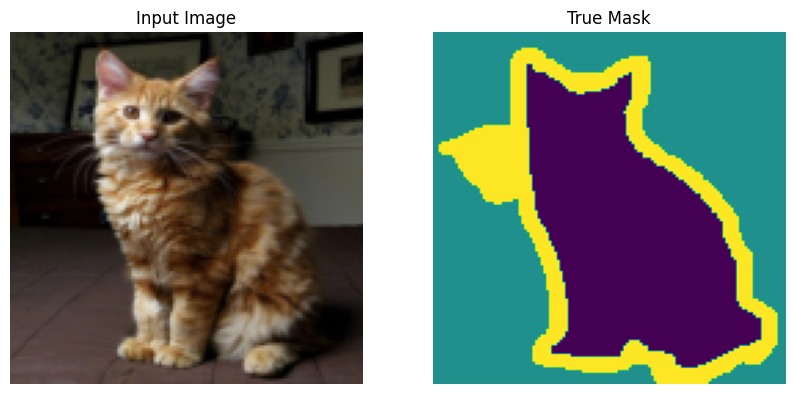

In [13]:
def display_sample(image, mask):
    """Shows an image and its corresponding mask."""
    # Un-normalize the image for display
    unnormalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = unnormalize(image)
    image = image.permute(1, 2, 0).cpu().numpy()
    mask = mask.cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("True Mask")
    plt.imshow(mask)
    plt.axis('off')
    
    plt.show()

# Display one image and its mask from a training batch
images, masks = next(iter(train_loader))
display_sample(images[0], masks[0])

# 🏗️ Part 6: Building the U-Net Model in PyTorch

In this part, we'll define the **U-Net architecture** using PyTorch's `nn.Module`. U-Net follows an **encoder-decoder structure** with skip connections and is composed of repeated convolutional blocks.

---

## 🔁 Reusable Block: DoubleConv

We’ll first define a reusable `DoubleConv` block that consists of:

- Two `Conv2d` layers
- Followed by `ReLU` activations
- Optionally includes `BatchNorm2d` (depending on design)

This block forms the building unit of both the encoder and decoder.

---

## 🔻 Encoder

- The **encoder** consists of a sequence of:
  - `DoubleConv` blocks
  - Followed by `MaxPool2d` layers for downsampling
- It captures **contextual features** by reducing spatial dimensions and increasing depth.

---

## 🔺 Decoder

- The **decoder** performs upsampling using:
  - `ConvTranspose2d` layers
  - Concatenates the corresponding **skip connection** from the encoder
  - Then passes the result through a `DoubleConv` block
- It enables **precise localization** by recovering spatial details.

---

## 🎯 Final Output Layer

- A **1×1 `Conv2d`** is used at the end to map the feature channels to the **number of output classes**.
- This generates the final **segmentation map**, with class labels assigned per pixel.

---

With this modular design, we can easily build and customize the U-Net architecture for our segmentation task.


In [14]:
class DoubleConv(nn.Module):
    """(Convolution => ReLU => Batch Normalization) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.MaxPool2d(2)
        self.conv1 = DoubleConv(64, 128)
        self.down2 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(128, 256)
        self.down3 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(256, 512)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(512, 256) # 256 from up1 + 256 from conv2
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(256, 128) # 128 from up2 + 128 from conv1
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(128, 64) # 64 from up3 + 64 from inc
        
        # Output layer
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.conv1(x2)
        x3 = self.down2(x2)
        x3 = self.conv2(x3)
        x4 = self.down3(x3)
        x4 = self.conv3(x4)
        
        # Decoder
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1) # Skip connection
        x = self.conv4(x)
        
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1) # Skip connection
        x = self.conv5(x)
        
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1) # Skip connection
        x = self.conv6(x)
        
        logits = self.outc(x)
        return logits

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=3).to(device)

# Print a summary to verify the architecture
_ = summary(model, input_size=(3, 128, 128))

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,792
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,928
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
├─MaxPool2d: 1-2                         --
├─DoubleConv: 1-3                        --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-7                  73,856
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 147,584
|    |    └─BatchNorm2d: 3-11            256
|    |    └─ReLU: 3-12                   --
├─MaxPool2d: 1-4                         --
├─DoubleConv: 1-5                        --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-13                 295,168
| 

# 🏋️‍♂️ Part 7 (Revised): Training and Validating the Model

In this section, we implement the **complete training loop** with an added **validation step** after each epoch. This allows us to monitor the model's performance on **unseen data** and helps detect overfitting.

---

## 🔁 Training + Validation Workflow

Each epoch includes two phases:

---

### 🔧 Training Phase (`model.train()`)

During training, the model **learns** by updating its weights. For each batch in the training set:

- Pass the input through the model
- Calculate the **CrossEntropyLoss**
- Perform **backpropagation** (`loss.backward()`)
- Update weights using the optimizer
- Track the **training accuracy** and loss

---

### 🧪 Validation Phase (`model.eval()`)

After each training epoch, we evaluate the model on the **validation set**:

- Switch the model to **evaluation mode** (`model.eval()`), which disables training-specific behaviors like Dropout and BatchNorm updates
- Use `torch.no_grad()` to avoid computing gradients
- Forward pass the inputs
- Compute **validation loss** and **accuracy**
- **Do not update weights** during this phase

---

## ✅ Why Validate?

- Helps track how well the model is **generalizing**
- Detects **overfitting** early
- Provides a more realistic view of performance

This approach ensures that our model isn’t just memorizing the training data but is truly learning to **segment unseen images effectively**.


In [15]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# --- Training and Validation Loop ---
num_epochs = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train() # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item() * images.size(0)
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += masks.nelement() # Total number of pixels
        correct_train += (predicted == masks).sum().item()

    # --- Validation Phase ---
    model.eval() # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # No need to track gradients for validation
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Accumulate validation loss
            running_val_loss += loss.item() * images.size(0)
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += masks.nelement() # Total number of pixels
            correct_val += (predicted == masks).sum().item()

    # --- Print Epoch Statistics ---
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct_train / total_train
    
    val_loss = running_val_loss / len(test_dataset)
    val_acc = 100 * correct_val / total_val
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("\nTraining finished! 🎉")

Epoch [1/7] | Train Loss: 0.7452, Train Acc: 71.26% | Val Loss: 0.5678, Val Acc: 79.34%
Epoch [2/7] | Train Loss: 0.5088, Train Acc: 81.36% | Val Loss: 0.4706, Val Acc: 82.51%
Epoch [3/7] | Train Loss: 0.4425, Train Acc: 83.47% | Val Loss: 0.4328, Val Acc: 83.88%
Epoch [4/7] | Train Loss: 0.4016, Train Acc: 84.72% | Val Loss: 0.3895, Val Acc: 85.19%
Epoch [5/7] | Train Loss: 0.3681, Train Acc: 85.98% | Val Loss: 0.3902, Val Acc: 85.08%
Epoch [6/7] | Train Loss: 0.3446, Train Acc: 86.83% | Val Loss: 0.3609, Val Acc: 86.13%
Epoch [7/7] | Train Loss: 0.3222, Train Acc: 87.70% | Val Loss: 0.3800, Val Acc: 85.36%

Training finished! 🎉


# 🎨 Part 8: Visualizing Predictions

After training, it's time to see how well our U-Net model performs on the test set.

We'll visualize the results by:

- Selecting a few **sample images** from the validation/test set
- Generating **predicted masks** using our trained model
- Displaying:
  - The **original input image**
  - The **ground truth segmentation mask**
  - The **predicted mask** by the model

---

## 🖼️ Side-by-Side Comparison

This side-by-side visualization helps us understand:

- How accurately the model identifies object boundaries
- Whether the model captures small details
- How close the predicted mask is to the ground truth

---

By qualitatively inspecting the outputs, we gain deeper insight into the model's strengths and areas for improvement.


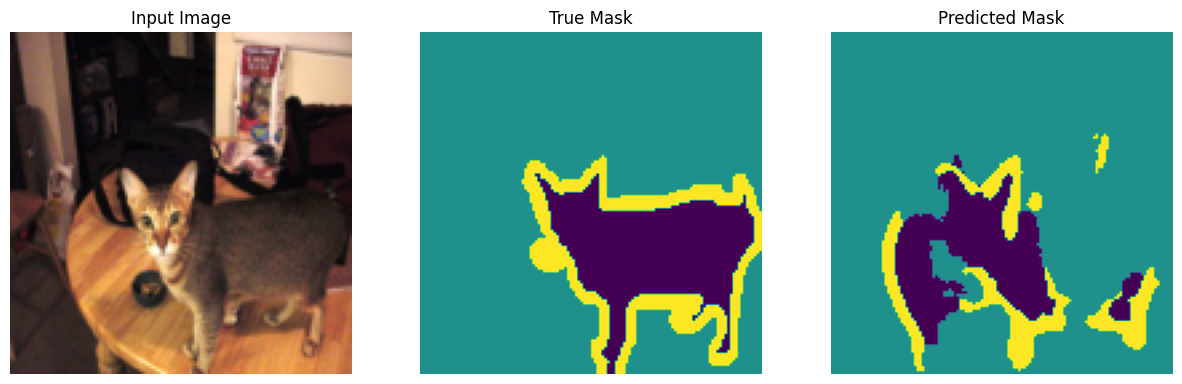

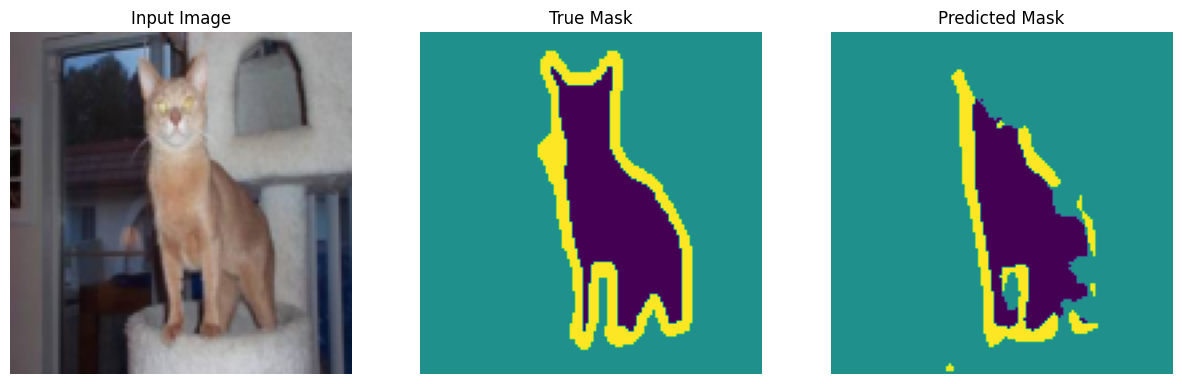

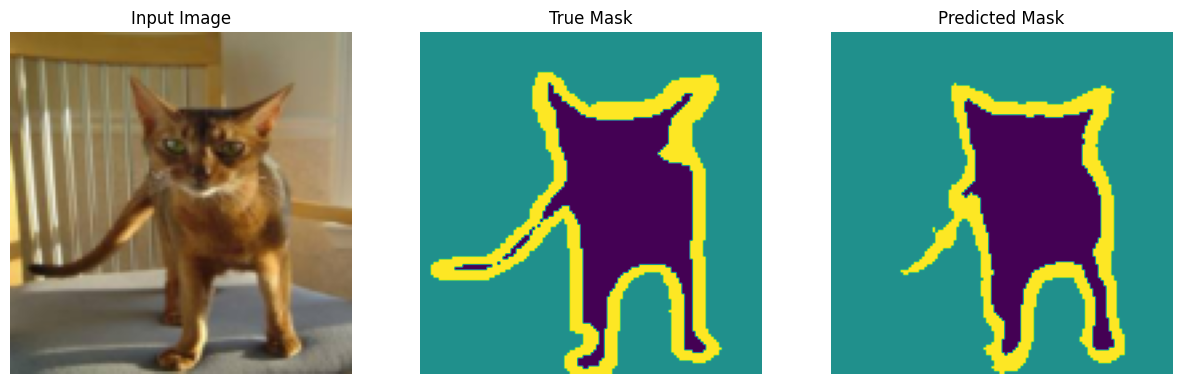

In [17]:
def show_predictions():
    model.eval() # Set the model to evaluation mode
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        # Get the predicted class for each pixel
        _, preds = torch.max(outputs, 1)

    for i in range(3): # Show predictions for the first 3 images in the batch
        # Un-normalize the image for display
        unnormalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img_to_show = unnormalize(images[i])
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img_to_show.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(masks[i].cpu().numpy())
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].cpu().numpy())
        plt.axis('off')
        
        plt.show()

# Show some predictions
show_predictions()

# 🧩 Part 9: How to Use Your Own Images

Adapting this notebook for your own dataset is straightforward. Here’s what you need to do:

---

## Organize Your Data

Create a main dataset folder. Inside it, create two subfolders:

- **images**: Place all your input images here (e.g., in .jpg or .png format).
- **masks**: Place all your corresponding segmentation masks here.

**Important:** The mask for `image_001.jpg` must have the exact same filename, `image_001.png`. The mask should be a grayscale image where each pixel's value corresponds to a class (e.g., 0 for background, 1 for person, 2 for car).

---

## Create a Custom Dataset

You will need to write a custom Dataset class similar to the `PetDataset` we created. Instead of wrapping the `OxfordIIITPet` class, it will:

- Read image and mask file paths
- Load them using a library like Pillow (PIL)
- Apply the transformations

---

## Adjust Model Parameters

In the `UNet` instantiation, change `n_classes` to match the number of classes in your dataset.

For example, if you are segmenting background, cats, and dogs, you would have:

```python
n_classes = 3
